# Predicting future environmental intensity (Time Series) and Collect Pilot Stocks Companies Descriptions

In this notebook, we will predict future environmental intensity for all the companies in the 'Excel data'. We will be using data from previous years to predict the future environmental intesity. 

First, we will create the following columns:

1) Industry Indicator
- 1 if above the industry average in current year
- 0 if at industry average in current yeat
- (-1) if below the industry average in current year
2) Environmental Intensity Growth : ((Environmental Intensity in Current Year / Environmental Intensity Last Year) - 1) * 100


At the end, we collected, directly from Yahoo Finance website, each company description. For this, we use the pilot stocks which have the Ticker identifier. 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import warnings
from sklearn import linear_model
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import requests
from bs4 import BeautifulSoup
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('/Users/maralinetorres/Documents/GitHub/Predicting-Environmental-and-Social-Actions/Datasets/Environmental_impact_cleaned.csv')
print(f'The dataset has {df.shape[0]} rows and {df.shape[1]} columns')
df.head(3)

The dataset has 14515 rows and 39 columns


,ISIN,Year,CompanyName,Country,Industry(Exiobase),EnvironmentalIntensity(Sales),EnvironmentalIntensity(OpInc),TotalEnvironmentalCost,WorkingCapacity,FishProductionCapacity,...,SDG14.c,SDG15.1,SDG15.2,SDG15.5,%Imputed,Env_intensity,industry_avg,industry_avg_year,Industry_indicator_year,Environmental_Growth
0,DE0005545503,2016,1&1 DRILLISCH AG,Germany,Post and telecommunications (64),-0.07%,-0.82%,"-539,318","-525,027",-169,...,-6,67,67,-22,23%,-0.0007,-0.020506,-0.020740,1,NaN
1,GB00B1YW4409,2010,3I GROUP PLC,United Kingdom,"Financial intermediation, except insurance and...",-0.12%,-0.11%,"-1,055,812","-1,032,103",-277,...,-4,51,51,-43,10%,-0.0012,-0.028537,-0.006402,1,NaN
2,GB00B1YW4409,2011,3I GROUP PLC,United Kingdom,"Financial intermediation, except insurance and...",-0.16%,-0.16%,"-961,875","-940,402",-246,...,-3,38,38,-39,9%,-0.0016,-0.028537,-0.009838,1,33.333333


Now, we are going to subset for the columns that we are interested in. As discussed in the notebook 'Environmental-Impact-Data Cleaning', we transformed the EnvironmentalIntensity(Sales) to decimals and removed spaces in columns CompanyName and Country. 

In [3]:
df = df.loc[:,['ISIN','Year','CompanyName','Country','Industry(Exiobase)','EnvironmentalIntensity(Sales)','Env_intensity']]
df.head()

,ISIN,Year,CompanyName,Country,Industry(Exiobase),EnvironmentalIntensity(Sales),Env_intensity
0,DE0005545503,2016,1&1 DRILLISCH AG,Germany,Post and telecommunications (64),-0.07%,-0.0007
1,GB00B1YW4409,2010,3I GROUP PLC,United Kingdom,"Financial intermediation, except insurance and...",-0.12%,-0.0012
2,GB00B1YW4409,2011,3I GROUP PLC,United Kingdom,"Financial intermediation, except insurance and...",-0.16%,-0.0016
3,GB00B1YW4409,2012,3I GROUP PLC,United Kingdom,"Financial intermediation, except insurance and...",-0.15%,-0.0015
4,US88579Y1010,2010,3M COMPANY,United States,Activities of membership organisation n.e.c. (91),-7.90%,-0.0790


### Creating industry indicator

In [4]:
industry_avg = df.groupby('Industry(Exiobase)')[['Env_intensity']].mean().reset_index()
df['industry_avg'] = df['Env_intensity'].groupby(df['Industry(Exiobase)']).transform('mean')

In [5]:
def create_ind(df):
    if(df['Env_intensity'] > df['industry_avg']):
        return 1
    elif (df['Env_intensity'] == df['industry_avg']):
        return 0
    elif (df['Env_intensity'] < df['industry_avg']):
        return -1

df['Industry_indicator'] = df.apply(create_ind, axis = 1)
df.head()

,ISIN,Year,CompanyName,Country,Industry(Exiobase),EnvironmentalIntensity(Sales),Env_intensity,industry_avg,Industry_indicator
0,DE0005545503,2016,1&1 DRILLISCH AG,Germany,Post and telecommunications (64),-0.07%,-0.0007,-0.020506,1
1,GB00B1YW4409,2010,3I GROUP PLC,United Kingdom,"Financial intermediation, except insurance and...",-0.12%,-0.0012,-0.028537,1
2,GB00B1YW4409,2011,3I GROUP PLC,United Kingdom,"Financial intermediation, except insurance and...",-0.16%,-0.0016,-0.028537,1
3,GB00B1YW4409,2012,3I GROUP PLC,United Kingdom,"Financial intermediation, except insurance and...",-0.15%,-0.0015,-0.028537,1
4,US88579Y1010,2010,3M COMPANY,United States,Activities of membership organisation n.e.c. (91),-7.90%,-0.0790,-0.175838,1


In [6]:
def create_ind_year(df):
    if(df['Env_intensity'] > df['industry_avg_year']):
        return 1
    elif (df['Env_intensity'] == df['industry_avg_year']):
        return 0
    elif (df['Env_intensity'] < df['industry_avg_year']):
        return -1

df['industry_avg_year'] = df.groupby(['Industry(Exiobase)','Year']).transform('mean')[['Env_intensity']]

df['Industry_indicator_year'] = df.apply(create_ind_year, axis = 1)
df.head()

,ISIN,Year,CompanyName,Country,Industry(Exiobase),EnvironmentalIntensity(Sales),Env_intensity,industry_avg,Industry_indicator,industry_avg_year,Industry_indicator_year
0,DE0005545503,2016,1&1 DRILLISCH AG,Germany,Post and telecommunications (64),-0.07%,-0.0007,-0.020506,1,-0.020740,1
1,GB00B1YW4409,2010,3I GROUP PLC,United Kingdom,"Financial intermediation, except insurance and...",-0.12%,-0.0012,-0.028537,1,-0.006402,1
2,GB00B1YW4409,2011,3I GROUP PLC,United Kingdom,"Financial intermediation, except insurance and...",-0.16%,-0.0016,-0.028537,1,-0.009838,1
3,GB00B1YW4409,2012,3I GROUP PLC,United Kingdom,"Financial intermediation, except insurance and...",-0.15%,-0.0015,-0.028537,1,-0.024437,1
4,US88579Y1010,2010,3M COMPANY,United States,Activities of membership organisation n.e.c. (91),-7.90%,-0.0790,-0.175838,1,-0.084583,1


In [7]:
df.loc[(df['Industry(Exiobase)'] == 'Activities auxiliary to financial intermediation (67)'),:].sort_values(by='Year')

,ISIN,Year,CompanyName,Country,Industry(Exiobase),EnvironmentalIntensity(Sales),Env_intensity,industry_avg,Industry_indicator,industry_avg_year,Industry_indicator_year
190,CH0012138605,2010,ADECCO GROUP AG,Switzerland,Activities auxiliary to financial intermediati...,-0.14%,-0.0014,-0.00491,1,-0.004490,1
2052,GB00B23K0M20,2010,CAPITA PLC,United Kingdom,Activities auxiliary to financial intermediati...,-0.40%,-0.0040,-0.00491,1,-0.004490,1
1919,FR0006174348,2010,BUREAU VERITAS SA,France,Activities auxiliary to financial intermediati...,-0.52%,-0.0052,-0.00491,-1,-0.004490,-1
3524,DE0005810055,2010,DEUTSCHE BOERSE AG,Germany,Activities auxiliary to financial intermediati...,-0.28%,-0.0028,-0.00491,1,-0.004490,1
1718,ES0115056139,2010,BOLSAS Y MERCADOS ESPANOLES SHMSF SA,Spain,Activities auxiliary to financial intermediati...,-0.26%,-0.0026,-0.00491,1,-0.004490,1
...,...,...,...,...,...,...,...,...,...,...,...
4428,GB00B19NLV48,2019,EXPERIAN PLC,United Kingdom,Activities auxiliary to financial intermediati...,-0.20%,-0.0020,-0.00491,1,0.002943,-1
979,FR0000074148,2019,ASSYSTEM SA,France,Activities auxiliary to financial intermediati...,-0.31%,-0.0031,-0.00491,1,0.002943,-1
3529,DE0005810055,2019,DEUTSCHE BOERSE AG,Germany,Activities auxiliary to financial intermediati...,1.88%,0.0188,-0.00491,1,0.002943,1
9793,GB0030232317,2019,PAGEGROUP PLC,United Kingdom,Activities auxiliary to financial intermediati...,-0.08%,-0.0008,-0.00491,1,0.002943,-1


### Creating Environmental growth

Environmental Intensity Growth : ((Environmental Intensity in Current Year / Environmental Intensity Last Year) - 1) * 100

In [8]:
df = df.sort_values(by=['CompanyName','Year'], ascending = True)
df.head()

,ISIN,Year,CompanyName,Country,Industry(Exiobase),EnvironmentalIntensity(Sales),Env_intensity,industry_avg,Industry_indicator,industry_avg_year,Industry_indicator_year
0,DE0005545503,2016,1&1 DRILLISCH AG,Germany,Post and telecommunications (64),-0.07%,-0.0007,-0.020506,1,-0.020740,1
1,GB00B1YW4409,2010,3I GROUP PLC,United Kingdom,"Financial intermediation, except insurance and...",-0.12%,-0.0012,-0.028537,1,-0.006402,1
2,GB00B1YW4409,2011,3I GROUP PLC,United Kingdom,"Financial intermediation, except insurance and...",-0.16%,-0.0016,-0.028537,1,-0.009838,1
3,GB00B1YW4409,2012,3I GROUP PLC,United Kingdom,"Financial intermediation, except insurance and...",-0.15%,-0.0015,-0.028537,1,-0.024437,1
4,US88579Y1010,2010,3M COMPANY,United States,Activities of membership organisation n.e.c. (91),-7.90%,-0.0790,-0.175838,1,-0.084583,1


In [9]:
df['Environmental_Growth'] = df.groupby(['CompanyName'])['Env_intensity'].apply(lambda x: x.pct_change()).to_numpy() * 100
df.head()

,ISIN,Year,CompanyName,Country,Industry(Exiobase),EnvironmentalIntensity(Sales),Env_intensity,industry_avg,Industry_indicator,industry_avg_year,Industry_indicator_year,Environmental_Growth
0,DE0005545503,2016,1&1 DRILLISCH AG,Germany,Post and telecommunications (64),-0.07%,-0.0007,-0.020506,1,-0.020740,1,NaN
1,GB00B1YW4409,2010,3I GROUP PLC,United Kingdom,"Financial intermediation, except insurance and...",-0.12%,-0.0012,-0.028537,1,-0.006402,1,NaN
2,GB00B1YW4409,2011,3I GROUP PLC,United Kingdom,"Financial intermediation, except insurance and...",-0.16%,-0.0016,-0.028537,1,-0.009838,1,33.333333
3,GB00B1YW4409,2012,3I GROUP PLC,United Kingdom,"Financial intermediation, except insurance and...",-0.15%,-0.0015,-0.028537,1,-0.024437,1,-6.250000
4,US88579Y1010,2010,3M COMPANY,United States,Activities of membership organisation n.e.c. (91),-7.90%,-0.0790,-0.175838,1,-0.084583,1,NaN


### Model 1 - Past years Environmental Intensity

In [10]:
df1 = df.copy()

In [11]:
def p2f(x):
    return float(x.strip('%'))/100
df1['EnvironmentalIntensity(Sales)'] = df1['EnvironmentalIntensity(Sales)'].apply(p2f)

In [12]:
companies_2018 = list(df1[df1['Year'] == 2018]['CompanyName'])
companies_2019 = list(df1[(df1['Year'] == 2019) & (df1['CompanyName'].isin(companies_2018))]['CompanyName'])

#Getting companies that are in both years
list2018_as_set = set(companies_2018)
intersection = list2018_as_set.intersection(companies_2019)

X = df1[(df1['Year'] == 2018) & (df1['CompanyName'].isin(intersection))][['Env_intensity']]
y = df1[(df1['Year'] == 2019) & (df1['CompanyName'].isin(intersection))][['Env_intensity']]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)


reg = LinearRegression().fit(X_train, y_train)

y_pred = reg.predict(X_test)

print('R2 score:', metrics.r2_score(y_test, y_pred))
print('MSE: ', metrics.mean_squared_error(y_test, y_pred))


R2 score: 0.8535746128153976
MSE:  0.015251450150102281


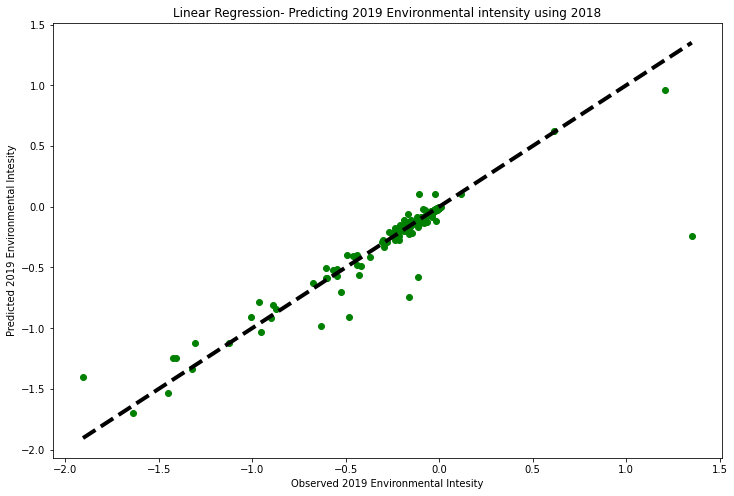

In [13]:
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(y_test, y_pred, c='green')
ax.plot([y_test.min(), y_test.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Observed 2019 Environmental Intesity')
ax.set_ylabel('Predicted 2019 Environmental Intesity')
ax.set_title('Linear Regression- Predicting 2019 Environmental intensity using 2018');

### Including Multiple Years

Starting with 2017 & 2018 to predict values in 2019

In [14]:
companies_2017 = list(df1[df1['Year'] == 2017]['CompanyName'])
list2017_as_set = set(companies_2017)
intersection2= list2017_as_set.intersection(intersection)

X = df1[(df1['Year'].isin([2017, 2018])) & (df1['CompanyName'].isin(intersection2))][['CompanyName','EnvironmentalIntensity(Sales)']]
X = X.groupby('CompanyName').mean()[['EnvironmentalIntensity(Sales)']]

y = df1[(df1['Year'] == 2019) & (df1['CompanyName'].isin(intersection2))][['EnvironmentalIntensity(Sales)']]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)


reg = LinearRegression().fit(X_train, y_train)

y_pred = reg.predict(X_test)


print('R2 score:', metrics.r2_score(y_test, y_pred))
print('MSE: ', metrics.mean_squared_error(y_test, y_pred))
print('Adjusted R2: ', 1-(1-.83729)*(len(intersection2)-1)/(len(intersection2)-2-1))

R2 score: 0.9640133945498272
MSE:  0.0028344652171312934
Adjusted R2:  0.8370169966442953


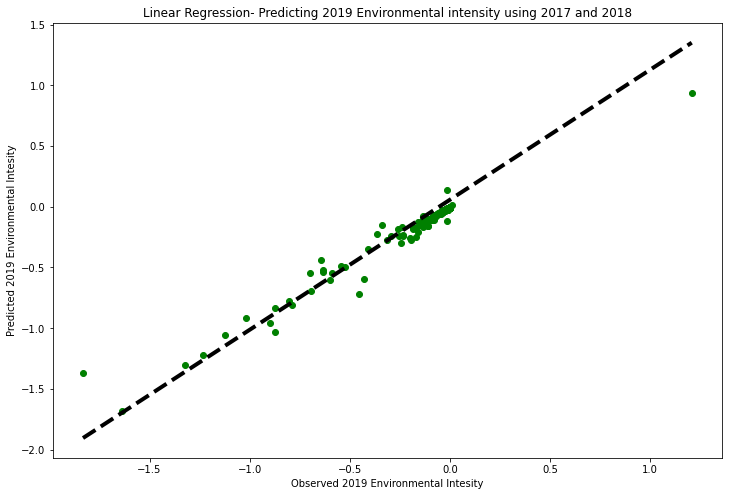

In [15]:
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(y_test, y_pred, c='green')
ax.plot([y_test.min(), y_test.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Observed 2019 Environmental Intesity')
ax.set_ylabel('Predicted 2019 Environmental Intesity')
ax.set_title('Linear Regression- Predicting 2019 Environmental intensity using 2017 and 2018');

We see that the results of this model are worse than our first model which predicted 2019 numbers with 2018. We go on to include 2017.

In [16]:
companies_2016 = list(df1[df1['Year'] == 2016]['CompanyName'])
list2016_as_set = set(companies_2016)
intersection3= list2016_as_set.intersection(intersection2)

X = df1[(df1['Year'].isin([2016, 2017, 2018])) & (df1['CompanyName'].isin(intersection3))][['CompanyName','EnvironmentalIntensity(Sales)']]
X = X.groupby('CompanyName').mean()[['EnvironmentalIntensity(Sales)']]

y = df1[(df1['Year'] == 2019) & (df1['CompanyName'].isin(intersection3))][['EnvironmentalIntensity(Sales)']]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)


reg = LinearRegression().fit(X_train, y_train)

y_pred = reg.predict(X_test)

print('R2 score:', metrics.r2_score(y_test, y_pred))
print('MSE: ', metrics.mean_squared_error(y_test, y_pred))
print('Adjusted R2: ', 1-(1-.92741)*(len(intersection3)-1)/(len(intersection3)-3-1))

R2 score: 0.916454447105587
MSE:  0.00421395537780839
Adjusted R2:  0.9272047502356268


When we include 2016 both our R score and MSE improved.

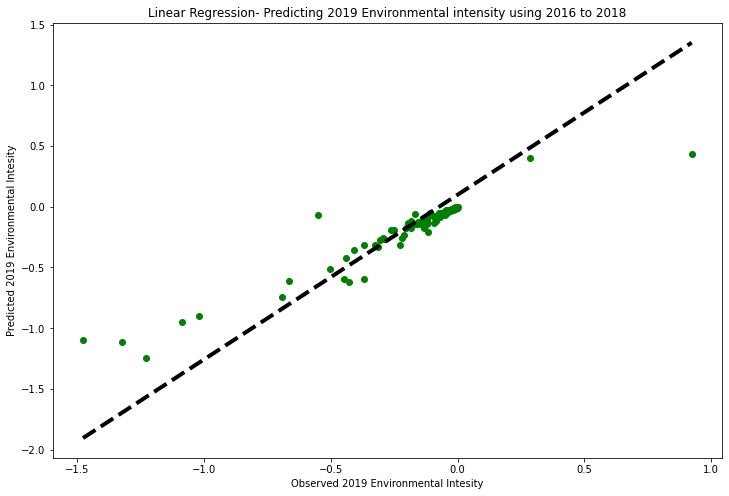

In [17]:
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(y_test, y_pred, c='green')
ax.plot([y_test.min(), y_test.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Observed 2019 Environmental Intesity')
ax.set_ylabel('Predicted 2019 Environmental Intesity')
ax.set_title('Linear Regression- Predicting 2019 Environmental intensity using 2016 to 2018');

### Model 2 - Past years average environmental intensity

In this section, we will use the average environmental intensity of 2016-2018 to predict 2019 environmental intensity

In [18]:
df2 = df.copy()
EI_2016 = df2[df2['Year'] == 2016]
EI_2017 = df2[df2['Year'] == 2017]
EI_2018 = df2[df2['Year'] == 2018]
EI_2019 = df2[df2['Year'] == 2019]

In [19]:
df_mod2 = EI_2016.merge(EI_2017, how='inner', on='CompanyName', suffixes=('_2016', '_2017'))
df_mod2 = df_mod2.merge(EI_2018, how='inner', on='CompanyName')
df_mod2 = df_mod2.merge(EI_2019, how='inner', on='CompanyName', suffixes=('_2018', '_2019'))

In [20]:
df_mod2 = df_mod2[['CompanyName','Year_2016','Env_intensity_2016','Year_2017','Env_intensity_2017','Year_2018','Env_intensity_2018','Year_2019','Env_intensity_2019']]

In [21]:
df_mod2.head()

,CompanyName,Year_2016,Env_intensity_2016,Year_2017,Env_intensity_2017,Year_2018,Env_intensity_2018,Year_2019,Env_intensity_2019
0,3M COMPANY,2016,-0.0705,2017,-0.0660,2018,-0.0710,2019,-0.0641
1,A.G.V. PRODUCTS CORP,2016,-0.0170,2017,-0.0190,2018,-0.0140,2019,-0.0172
2,AA PLC,2016,-0.0130,2017,-0.0124,2018,-0.0117,2019,-0.0070
3,AAC TECHNOLOGIES HOLDINGS INCORPORATION,2016,-0.0389,2017,-0.0591,2018,-0.0802,2019,-0.1080
4,AAREAL BANK AG,2016,-0.0024,2017,-0.0021,2018,-0.0019,2019,-0.0015


In [22]:
df_melt2 = pd.melt(df_mod2, id_vars=['CompanyName'], value_vars=['Env_intensity_2016','Env_intensity_2016','Env_intensity_2017'],
        var_name='myVarname', value_name='Environmental_intenrsity')

In [23]:
df_melt2.head()

,CompanyName,myVarname,Environmental_intenrsity
0,3M COMPANY,Env_intensity_2016,-0.0705
1,A.G.V. PRODUCTS CORP,Env_intensity_2016,-0.0170
2,AA PLC,Env_intensity_2016,-0.0130
3,AAC TECHNOLOGIES HOLDINGS INCORPORATION,Env_intensity_2016,-0.0389
4,AAREAL BANK AG,Env_intensity_2016,-0.0024


In [24]:
ei_avg = df_melt2.groupby('CompanyName').mean().reset_index()
X = ei_avg[['Environmental_intenrsity']]
y = df_mod2[['Env_intensity_2019']]

print(X.shape)
print(y.shape)

(1065, 1)
(1065, 1)


In [25]:
x_train, x_test, y_train, y_test = train_test_split(X ,y, test_size = 0.2, random_state = 42)
# train Linear Regression
LRtrainer = LinearRegression()
LRtrainer.fit(x_train,y_train)

# mse for linear regression
y_pred_lr = LRtrainer.predict(x_test)
print(metrics.mean_squared_error(y_pred_lr, y_test))

0.006269966737857914


In [26]:
# display the parameters
print('Model intercept: ', LRtrainer.intercept_)
print('Model coefficients: ', LRtrainer.coef_)

Model intercept:  [-0.0051724]
Model coefficients:  [[0.80432622]]


In [27]:
print('R2 score:', metrics.r2_score(y_test, y_pred_lr))

R2 score: 0.8756921251462437


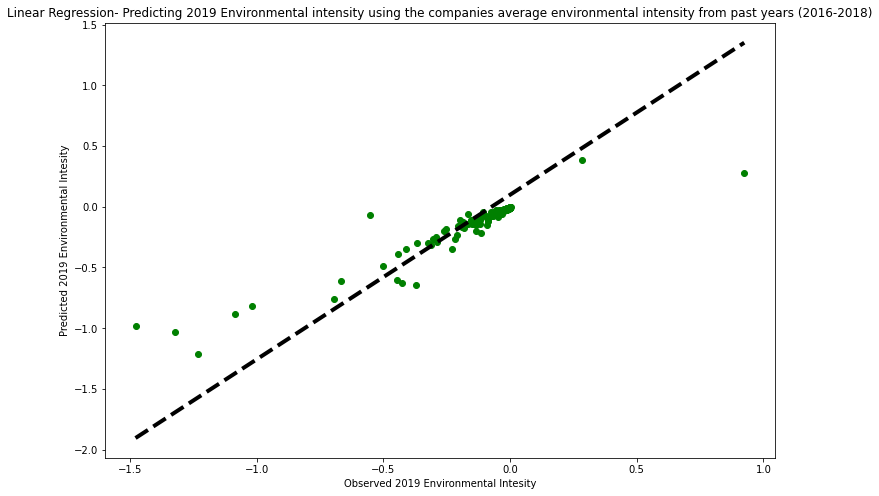

In [28]:
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(y_test, y_pred_lr, c='green')
ax.plot([y_test.min(), y_test.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Observed 2019 Environmental Intesity')
ax.set_ylabel('Predicted 2019 Environmental Intesity')
ax.set_title('Linear Regression- Predicting 2019 Environmental intensity using the companies average environmental intensity from past years (2016-2018)');

### Model 3 - Yearly Industry Average

For this model, the predictor will be the industry average for the respective year. 
There is no data for 2020, so we plan to predict 2019 environmental intensity.  Accordingly, we used 2018 and 2017 Industry data (past data) to predict 2019 evronmental intensity. 

<AxesSubplot:xlabel='Year', ylabel='count'>

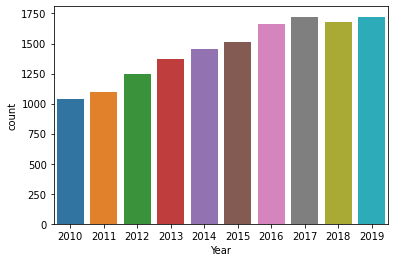

In [29]:
sns.countplot(x='Year', data = df)

The dataset does not contain consistent records throught out the years. Therefore, it could be possible we have data for one company in 2019 but not data from that company in 2018, 2017, etc. 

We will start by only using 2018 industry average as a feature to predict 2019 environmental intensity. First, we will subset the companies that we have 2018 data and get their 2019 environmental intensity. Also, we will keep the industries that have more than 3 companies assigned to them. 

In [30]:
df_industry = df.groupby('Industry(Exiobase)').count()['CompanyName'].reset_index()

industries = df_industry[df_industry['CompanyName'] > 3]['Industry(Exiobase)']

In [31]:
df_industry_count4 = df[df['Industry(Exiobase)'].isin(industries)]


df_2018 = df_industry_count4.loc[df.Year == 2018, ]
df_2019 = df_industry_count4.loc[df.Year == 2019, ]
df_mod3 = pd.merge(df_2018, df_2019, on='CompanyName',how='inner')
df_mod3 = df_mod3[['Year_x','CompanyName','industry_avg_year_x','Year_y','Env_intensity_y']]
df_mod3.head()

,Year_x,CompanyName,industry_avg_year_x,Year_y,Env_intensity_y
0,2018,3M COMPANY,-0.229308,2019,-0.0641
1,2018,3SBIO INC,-0.027793,2019,-0.0340
2,2018,A.G.V. PRODUCTS CORP,-0.072254,2019,-0.0172
3,2018,AA PLC,-0.073777,2019,-0.0070
4,2018,AAC TECHNOLOGIES HOLDINGS INCORPORATION,-0.023555,2019,-0.1080


In [32]:
X = df_mod3[['industry_avg_year_x']]
y = df_mod3.iloc[:,4]
print(X.shape)
print(y.shape)

(1336, 1)
(1336,)


In [33]:
x_train, x_test, y_train, y_test = train_test_split(X ,y, test_size = 0.2, random_state = 42)
# train Linear Regression
LRtrainer = LinearRegression()
LRtrainer.fit(x_train,y_train)

# mse for linear regression
y_pred_lr = LRtrainer.predict(x_test)
print(metrics.mean_squared_error(y_pred_lr, y_test))

0.06598743409385226


In [34]:
# display the parameters
print('Model intercept: ', LRtrainer.intercept_)
print('Model coefficients: ', LRtrainer.coef_)

Model intercept:  0.0002669631900767966
Model coefficients:  [0.91303819]


In [35]:
print('R2 score:', metrics.r2_score(y_test, y_pred_lr))

R2 score: 0.36647102462935643


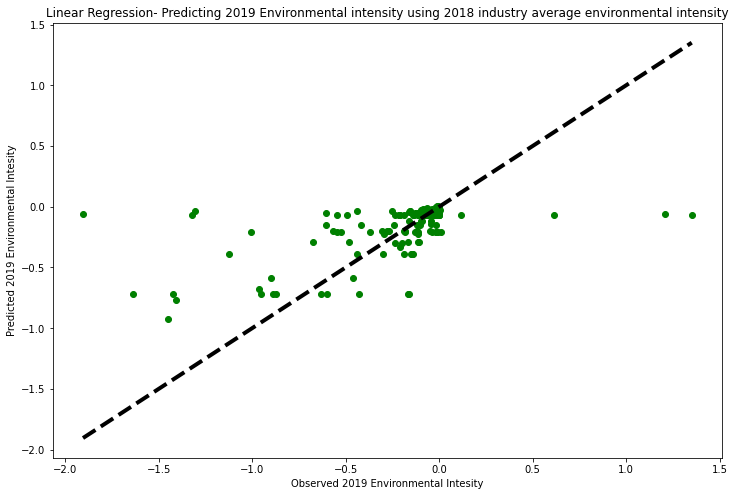

In [36]:
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(y_test, y_pred_lr, c='green')
ax.plot([y_test.min(), y_test.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Observed 2019 Environmental Intesity')
ax.set_ylabel('Predicted 2019 Environmental Intesity')
ax.set_title('Linear Regression- Predicting 2019 Environmental intensity using 2018 industry average environmental intensity');

Now, we are going to consider 2017 - 2018 to predict 2019

In [37]:
df_2019=df_industry_count4[df_industry_count4['Year'] == 2019]
df_2018=df_industry_count4[df_industry_count4['Year'] == 2018]
df_2017=df_industry_count4[df_industry_count4['Year'] == 2017]

In [38]:
df2019=df_2019[['Year','CompanyName','Env_intensity']] 
df2019.rename(columns={'Env_intensity': 'Env_intensity2019'}, inplace=True) 
df2018=df_2018[['CompanyName','industry_avg_year']]
df2018.rename(columns={'industry_avg_year': 'Ind_Yearavg2018'}, inplace=True) 
df2017=df_2017[['CompanyName','industry_avg_year']]
df2017.rename(columns={'industry_avg_year': 'Ind_Yearavg2017'}, inplace=True) 
mdl = pd.merge(df2019, df2018, on=["CompanyName"])
mdl1= pd.merge(mdl, df2017, on=["CompanyName"])
mdl1

,Year,CompanyName,Env_intensity2019,Ind_Yearavg2018,Ind_Yearavg2017
0,2019,3M COMPANY,-0.0641,-0.229308,-0.225496
1,2019,3SBIO INC,-0.0340,-0.027793,-0.031771
2,2019,A.G.V. PRODUCTS CORP,-0.0172,-0.072254,-0.063618
3,2019,AA PLC,-0.0070,-0.073777,-0.096157
4,2019,AAC TECHNOLOGIES HOLDINGS INCORPORATION,-0.1080,-0.023555,-0.027254
...,...,...,...,...,...
1190,2019,ZEON CORPORATION,-0.0730,-0.218707,-0.275385
1191,2019,ZHEN DING TECHNOLOGY HOLDING LIMITED,-0.0602,-0.076812,-0.068294
1192,2019,ZIG SHENG INDUSTRIAL COMPANY LIMITED,-0.1615,-0.124750,-0.117456
1193,2019,ZORLU ENERJI AS,-0.3430,-1.012140,-0.578986


In [39]:
X=mdl1[['Ind_Yearavg2018','Ind_Yearavg2017']]
y=mdl1['Env_intensity2019']
print(X.shape)
print(y.shape)

(1195, 2)
(1195,)


In [40]:
regr = linear_model.LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
regr.fit(X_train, y_train)
y_train_pred = np.exp(regr.predict(X_train))
y_pred = np.exp(regr.predict(X_test))
y_test = np.exp(y_test)

In [41]:
print('MSE train: %.3f, test: %.3f' % (metrics.mean_squared_error(y_train, y_train_pred),
                metrics.mean_squared_error(y_test, y_pred)))

MSE train: 1.064, test: 0.038


In [42]:
# display the parameters
print('Model intercept: ', regr.intercept_)
print('Model coefficients: ', regr.coef_)

Model intercept:  0.0005763983280114432
Model coefficients:  [ 0.94555899 -0.06948928]


In [43]:
print('R2 score:', metrics.r2_score(y_test, y_pred))

R2 score: 0.26873239153605133


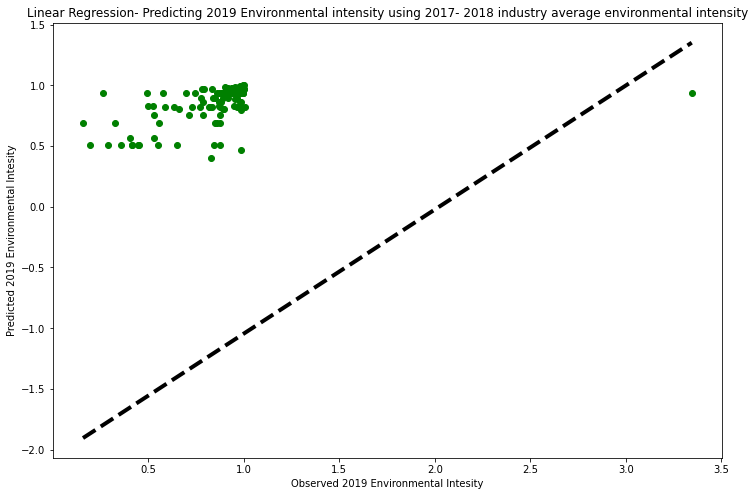

In [44]:
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(y_test, y_pred, c='green')
ax.plot([y_test.min(), y_test.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Observed 2019 Environmental Intesity')
ax.set_ylabel('Predicted 2019 Environmental Intesity')
ax.set_title('Linear Regression- Predicting 2019 Environmental intensity using 2017- 2018 industry average environmental intensity');

Using the industry environmental average for 2017 and 2018 only explained 27% of the variation in the dataset. Let's see what happens including 2016-2018 to predict 2019

In [45]:
df_2016 = df_industry_count4.loc[df_industry_count4.Year == 2016, ]
df_2017 = df_industry_count4.loc[df_industry_count4.Year == 2017, ]
df1 = df_2016.merge(df_2017, how='inner', on='CompanyName', suffixes=('_2016', '_2017'))
df1 = df1.merge(df_2018, how='inner', on='CompanyName')
df1 = df1.merge(df_2019, how='inner', on='CompanyName', suffixes=('_2018', '_2019'))
df1 = df1[['Year_2016','industry_avg_year_2016','Year_2017','industry_avg_year_2017','Year_2018','industry_avg_year_2018','Year_2019','Env_intensity_2019']]

In [46]:
X = df1[['industry_avg_year_2016','industry_avg_year_2017','industry_avg_year_2018']]
y = df1.iloc[:,7]
print(X.shape)
print(y.shape)

(1065, 3)
(1065,)


In [47]:
regr = linear_model.LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
regr.fit(X_train, y_train)
y_train_pred = regr.predict(X_train)
y_pred = regr.predict(X_test)

In [48]:
print('MSE train: %.3f, test: %.3f' % (metrics.mean_squared_error(y_train, y_train_pred),
                metrics.mean_squared_error(y_test, y_pred)))

MSE train: 0.033, test: 0.036


In [49]:
# display the parameters
print('Model intercept: ', regr.intercept_)
print('Model coefficients: ', regr.coef_)

Model intercept:  0.00568972196188465
Model coefficients:  [-0.22207005  0.34928786  0.78027233]


In [50]:
print('R2 score:', metrics.r2_score(y_test, y_pred))

R2 score: 0.28683072335691706


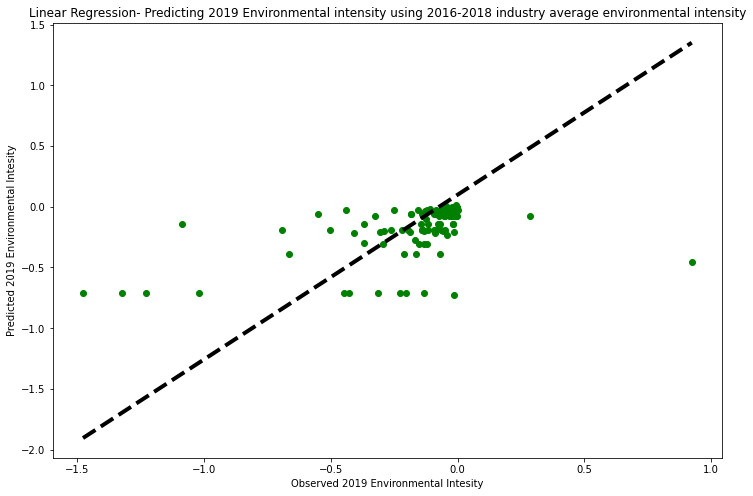

In [51]:
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(y_test, y_pred, c='green')
ax.plot([y_test.min(), y_test.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Observed 2019 Environmental Intesity')
ax.set_ylabel('Predicted 2019 Environmental Intesity')
ax.set_title('Linear Regression- Predicting 2019 Environmental intensity using 2016-2018 industry average environmental intensity');

### Model 4 -Yearly Industry Indicator

For this model, we will consider the yearly industry indicator from past years to predict the company 2019 environmental intensity. 

We are going to start from 2017-2018 to predict 2019. 

In [52]:
df_2019=df_industry_count4[df_industry_count4['Year'] == 2019]
df_2018=df_industry_count4[df_industry_count4['Year'] == 2018]
df_2017=df_industry_count4[df_industry_count4['Year'] == 2017]

df2019=df_2019[['Year','CompanyName','Env_intensity']] 
df2019.rename(columns={'Env_intensity': 'Env_intensity2019'}, inplace=True) 
df2018=df_2018[['CompanyName','Industry_indicator_year']]
df2018.rename(columns={'Industry_indicator_year': 'Ind_Indicator_2018'}, inplace=True) 
df2017=df_2017[['CompanyName','Industry_indicator_year']]
df2017.rename(columns={'Industry_indicator_year': 'Ind_Indicator_2017'}, inplace=True) 
mdl4 = pd.merge(df2019, df2018, on=["CompanyName"])
mdl4= pd.merge(mdl4, df2017, on=["CompanyName"])
mdl4

,Year,CompanyName,Env_intensity2019,Ind_Indicator_2018,Ind_Indicator_2017
0,2019,3M COMPANY,-0.0641,1,1
1,2019,3SBIO INC,-0.0340,-1,1
2,2019,A.G.V. PRODUCTS CORP,-0.0172,1,1
3,2019,AA PLC,-0.0070,1,1
4,2019,AAC TECHNOLOGIES HOLDINGS INCORPORATION,-0.1080,-1,-1
...,...,...,...,...,...
1190,2019,ZEON CORPORATION,-0.0730,1,1
1191,2019,ZHEN DING TECHNOLOGY HOLDING LIMITED,-0.0602,1,1
1192,2019,ZIG SHENG INDUSTRIAL COMPANY LIMITED,-0.1615,-1,-1
1193,2019,ZORLU ENERJI AS,-0.3430,1,1


In [53]:
X=mdl4[['Ind_Indicator_2017','Ind_Indicator_2018']]
y=mdl4['Env_intensity2019']
print(X.shape)
print(y.shape)

(1195, 2)
(1195,)


In [54]:
regr = linear_model.LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
regr.fit(X_train, y_train)
y_train_pred = regr.predict(X_train)
y_pred = regr.predict(X_test)

In [55]:
print('MSE train: %.3f, test: %.3f' % (metrics.mean_squared_error(y_train, y_train_pred),
                metrics.mean_squared_error(y_test, y_pred)))

MSE train: 0.048, test: 0.062


In [56]:
# display the parameters
print('Model intercept: ', regr.intercept_)
print('Model coefficients: ', regr.coef_)

Model intercept:  -0.15356410683376787
Model coefficients:  [0.03709691 0.07830873]


In [57]:
print('R2 score:', metrics.r2_score(y_test, y_pred))

R2 score: 0.21186363020947374


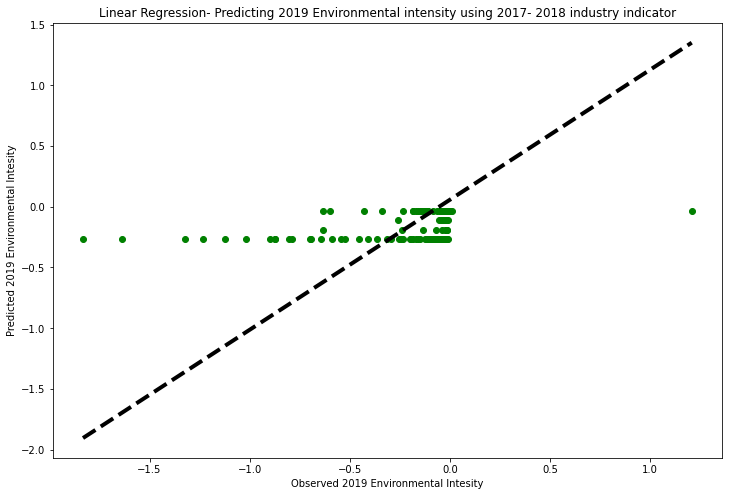

In [58]:
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(y_test, y_pred, c='green')
ax.plot([y_test.min(), y_test.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Observed 2019 Environmental Intesity')
ax.set_ylabel('Predicted 2019 Environmental Intesity')
ax.set_title('Linear Regression- Predicting 2019 Environmental intensity using 2017- 2018 industry indicator');

The industry indicator isn't a good predictor for environmental intensity. 

Let's try including 2016-2018 to predict 2019 environmental intensity. 

In [59]:
df_2016=df_industry_count4[df_industry_count4['Year'] == 2016]
df2016=df_2016[['CompanyName','Industry_indicator_year']]
df2016.rename(columns={'Industry_indicator_year': 'Ind_Indicator_2016'}, inplace=True) 

mdl4 = pd.merge(df2019, df2018, on=["CompanyName"])
mdl4= pd.merge(mdl4, df2017, on=["CompanyName"])
mdl4= pd.merge(mdl4, df2016, on=["CompanyName"])
mdl4.head()

,Year,CompanyName,Env_intensity2019,Ind_Indicator_2018,Ind_Indicator_2017,Ind_Indicator_2016
0,2019,3M COMPANY,-0.0641,1,1,1
1,2019,A.G.V. PRODUCTS CORP,-0.0172,1,1,1
2,2019,AA PLC,-0.0070,1,1,1
3,2019,AAC TECHNOLOGIES HOLDINGS INCORPORATION,-0.1080,-1,-1,-1
4,2019,AAREAL BANK AG,-0.0015,1,1,1


In [60]:
X = mdl4[['Ind_Indicator_2016','Ind_Indicator_2017','Ind_Indicator_2018']]
y = mdl4['Env_intensity2019']
print(X.shape)
print(y.shape)

(1065, 3)
(1065,)


In [61]:
regr = linear_model.LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
regr.fit(X_train, y_train)
y_train_pred = regr.predict(X_train)
y_pred = regr.predict(X_test)

print('MSE train: %.3f, test: %.3f' % (metrics.mean_squared_error(y_train, y_train_pred),
                metrics.mean_squared_error(y_test, y_pred)))

MSE train: 0.047, test: 0.039


In [62]:
# display the parameters
print('Model intercept: ', regr.intercept_)
print('Model coefficients: ', regr.coef_)

Model intercept:  -0.14924959083044503
Model coefficients:  [0.02269159 0.01672383 0.07522696]


In [63]:
print('R2 score:', metrics.r2_score(y_test, y_pred))

R2 score: 0.22699240460633197


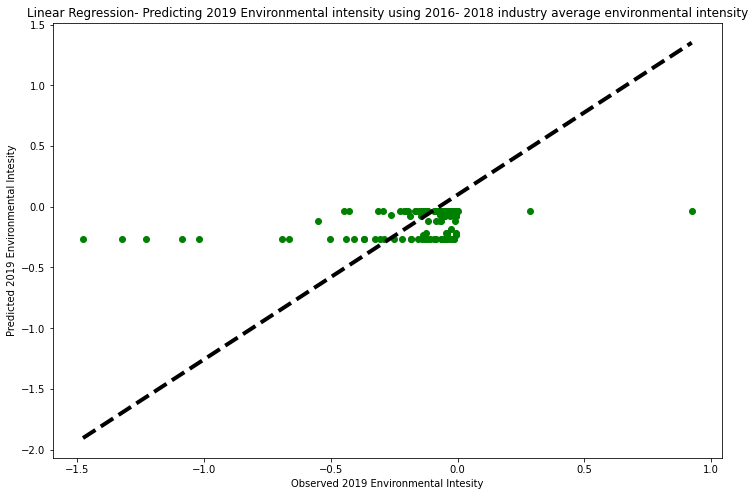

In [64]:
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(y_test, y_pred, c='green')
ax.plot([y_test.min(), y_test.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Observed 2019 Environmental Intesity')
ax.set_ylabel('Predicted 2019 Environmental Intesity')
ax.set_title('Linear Regression- Predicting 2019 Environmental intensity using 2016- 2018 industry average environmental intensity');

### Model 5 -Growth Rate

For this model, we will consider the growth rate from past years to predict the company 2019 environmental intensity.

We are going to start from 2017-2018 to predict 2019.

In [65]:
df_2019=df[df['Year'] == 2019]
df_2018=df[df['Year'] == 2018]
df_2017=df[df['Year'] == 2017]

df2019=df_2019[['Year','CompanyName','Env_intensity']] 
df2019.rename(columns={'Env_intensity': 'Env_intensity2019'}, inplace=True) 
df2018=df_2018[['CompanyName','Environmental_Growth']]
df2018.rename(columns={'Environmental_Growth': 'Environmental_Growth_2018'}, inplace=True) 
df2017=df_2017[['CompanyName','Environmental_Growth']]
df2017.rename(columns={'Environmental_Growth': 'Environmental_Growth_2017'}, inplace=True) 
mdl5 = pd.merge(df2019, df2018, on=["CompanyName"])
mdl5= pd.merge(mdl5, df2017, on=["CompanyName"])
mdl5

,Year,CompanyName,Env_intensity2019,Environmental_Growth_2018,Environmental_Growth_2017
0,2019,3M COMPANY,-0.0641,7.575758,-6.382979
1,2019,3SBIO INC,-0.0340,50.672646,NaN
2,2019,A.G.V. PRODUCTS CORP,-0.0172,-26.315789,11.764706
3,2019,AA PLC,-0.0070,-5.645161,-4.615385
4,2019,AAC TECHNOLOGIES HOLDINGS INCORPORATION,-0.1080,35.702200,51.928021
...,...,...,...,...,...
1190,2019,ZEON CORPORATION,-0.0730,-1.272265,-10.273973
1191,2019,ZHEN DING TECHNOLOGY HOLDING LIMITED,-0.0602,1.990050,-30.927835
1192,2019,ZIG SHENG INDUSTRIAL COMPANY LIMITED,-0.1615,-4.232425,-20.251716
1193,2019,ZORLU ENERJI AS,-0.3430,48.046057,-81.144737


In [66]:
mdl5.dropna(inplace = True)#delete rows with missing values
mdl5.shape

(1094, 5)

In [67]:
X=mdl5[['Environmental_Growth_2017','Environmental_Growth_2018']]
y=mdl5['Env_intensity2019']
print(X.shape)
print(y.shape)

(1094, 2)
(1094,)


In [68]:
regr = linear_model.LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
regr.fit(X_train, y_train)
y_train_pred = regr.predict(X_train)
y_pred = regr.predict(X_test)

In [69]:
print('MSE train: %.3f, test: %.3f' % (metrics.mean_squared_error(y_train, y_train_pred),
                metrics.mean_squared_error(y_test, y_pred)))

MSE train: 0.053, test: 0.083


In [70]:
# display the parameters
print('Model intercept: ', regr.intercept_)
print('Model coefficients: ', regr.coef_)

Model intercept:  -0.10344845492642087
Model coefficients:  [-1.28035334e-04 -8.51885195e-05]


In [71]:
print('R2 score:', metrics.r2_score(y_test, y_pred))

R2 score: 0.015827756484296907


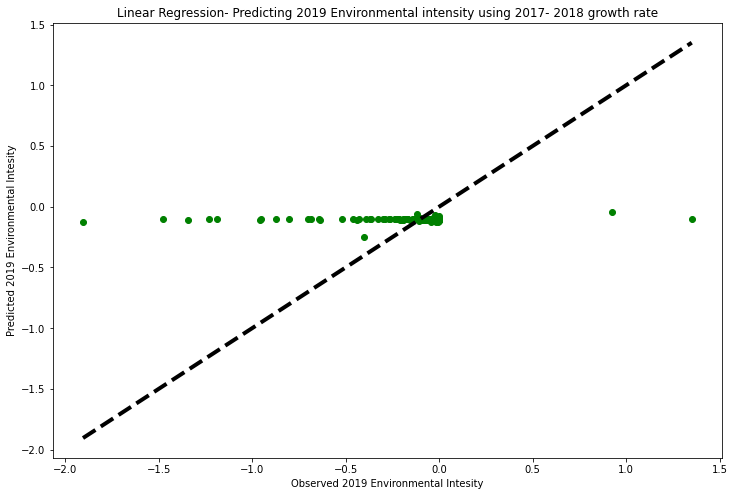

In [72]:
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(y_test, y_pred, c='green')
ax.plot([y_test.min(), y_test.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Observed 2019 Environmental Intesity')
ax.set_ylabel('Predicted 2019 Environmental Intesity')
ax.set_title('Linear Regression- Predicting 2019 Environmental intensity using 2017- 2018 growth rate');

The growth rate isn't a good predictor for environmental intensity. Let's try including 2016-2018 to predict 2019 environmental intensity.

In [73]:
df_2016=df[df['Year'] == 2016]
df_2016.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1666 entries, 0 to 14505
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   ISIN                           1666 non-null   object 
 1   Year                           1666 non-null   int64  
 2   CompanyName                    1666 non-null   object 
 3   Country                        1666 non-null   object 
 4   Industry(Exiobase)             1666 non-null   object 
 5   EnvironmentalIntensity(Sales)  1666 non-null   object 
 6   Env_intensity                  1666 non-null   float64
 7   industry_avg                   1666 non-null   float64
 8   Industry_indicator             1666 non-null   int64  
 9   industry_avg_year              1666 non-null   float64
 10  Industry_indicator_year        1666 non-null   int64  
 11  Environmental_Growth           1534 non-null   float64
dtypes: float64(4), int64(3), object(5)
memory usage

In [74]:
df_2016=df[df['Year'] == 2016]
df2016=df_2016[['CompanyName','Environmental_Growth']]
df2016.rename(columns={'Environmental_Growth': 'Environmental_Growth_2016'}, inplace=True) 

mdl5 = pd.merge(df2016, df2017, on=["CompanyName"])
mdl5= pd.merge(mdl5, df2018, on=["CompanyName"])
mdl5= pd.merge(mdl5, df2019, on=["CompanyName"])
mdl5.dropna(inplace=True)
mdl5.head()

,CompanyName,Environmental_Growth_2016,Environmental_Growth_2017,Environmental_Growth_2018,Year,Env_intensity2019
0,3M COMPANY,8.964451,-6.382979,7.575758,2019,-0.0641
1,A.G.V. PRODUCTS CORP,-13.265306,11.764706,-26.315789,2019,-0.0172
2,AA PLC,41.304348,-4.615385,-5.645161,2019,-0.0070
3,AAC TECHNOLOGIES HOLDINGS INCORPORATION,-7.159905,51.928021,35.702200,2019,-0.1080
4,AAREAL BANK AG,9.090909,-12.500000,-9.523810,2019,-0.0015


In [75]:
X=mdl5[['Environmental_Growth_2016','Environmental_Growth_2017','Environmental_Growth_2018']]
y=mdl5['Env_intensity2019']
print(X.shape)
print(y.shape)

(1010, 3)
(1010,)


In [76]:
regr = linear_model.LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
regr.fit(X_train, y_train)
y_train_pred = regr.predict(X_train)
y_pred = regr.predict(X_test)

print('MSE train: %.3f, test: %.3f' % (metrics.mean_squared_error(y_train, y_train_pred),
                metrics.mean_squared_error(y_test, y_pred)))

MSE train: 0.050, test: 0.057


In [77]:
# display the parameters
print('Model intercept: ', regr.intercept_)
print('Model coefficients: ', regr.coef_)

Model intercept:  -0.09843465299284881
Model coefficients:  [ 0.0001935  -0.00012326 -0.000327  ]


In [78]:
print('R2 score:', metrics.r2_score(y_test, y_pred))

R2 score: -0.018655694802211853


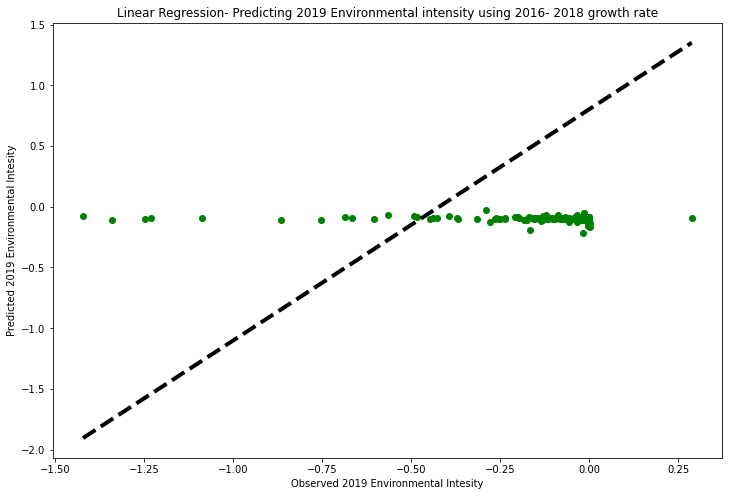

In [79]:
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(y_test, y_pred, c='green')
ax.plot([y_test.min(), y_test.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Observed 2019 Environmental Intesity')
ax.set_ylabel('Predicted 2019 Environmental Intesity')
ax.set_title('Linear Regression- Predicting 2019 Environmental intensity using 2016- 2018 growth rate');

Again, we see that each coefficient is negative which could be interpret that an increase in environmental growth decreases the environmental intensity for 2019. R1 score is also negative (is worse that a horizontal line) which mean we can discard this regression.

## Individual model conclusions

As expected, using Environmental intensity from previous years had better accuracy to predict the next year Environmental intensity. We proved that in Model 1 and Model 2 were the regression was able to explain 88% of the variance.

When using the industry average for each year, the model was able to explain around 30-34% of the variance. Moreover, by running these regressions, we concluded that the envirionmental growth from previous years isn't a good predictor.

However, maybe the industry indicator and growth rate would help explain the future environmental intensity better if we combine this features with previous models. For example, predicting 2019 environmental intensity using last years environmental intensity, industry indicator, average industry and growth rate. 

Let's see what happens!

## Building new predictive models by combinig features 

In this section, we will create a function to calculate the desired future environmental intensity using different features.
 

In [80]:
years = [2016, 2017, 2018]
df_c = df_industry_count4.copy()
def predictiveModel(outcomeYear, pastYears, df_c):
    years.sort()
    for year in years:
        data = df_c[df_c['Year'] == year]
        data = data.loc[:,['CompanyName','Env_intensity','industry_avg_year']]
        data.rename(columns={'Env_intensity': f'Env_intensity_{year}','industry_avg_year':f'industry_avg_year_{year}'}, inplace=True) 
        if(year == min(years)):
            data1 = pd.DataFrame(data)
        else:
            data2 = pd.merge(data1, data, on=["CompanyName"])
            data1 = data2.copy()
    data3 = df_c[df_c['Year'] == outcomeYear]
    data3 = data3[['CompanyName','Env_intensity','industry_avg_year']]
    data3.rename(columns={'Env_intensity': f'Env_intensity_{outcomeYear}','industry_avg_year':f'industry_avg_year_{outcomeYear}'}, inplace=True) 
    data3 = pd.merge(data3, data2, on=["CompanyName"])
    
    filter_col = [col for col in data3 if ((col.startswith('Env_intensity') and not(col.endswith(f'{outcomeYear}')))) or ((col.startswith('industry_avg_year') and not(col.endswith(f'{outcomeYear}'))))]
    outcome_col = [col for col in data3 if (col.startswith('Env_intensity') and col.endswith(f'{outcomeYear}'))]
    X=data3[filter_col]
    y=data3[outcome_col]
    
    regr = linear_model.LinearRegression()
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
    regr.fit(X_train, y_train)
    y_train_pred = regr.predict(X_train)
    y_pred = regr.predict(X_test)

    print('MSE train: %.3f, test: %.3f' % (metrics.mean_squared_error(y_train, y_train_pred),
                    metrics.mean_squared_error(y_test, y_pred)))
    
    # display the parameters
    print('Model intercept: ', regr.intercept_)
    print('Model coefficients: ', regr.coef_)
    
    print('R2 score:', metrics.r2_score(y_test, y_pred))
    
    fig, ax = plt.subplots(figsize=(12,8))
    ax.scatter(y_test, y_pred, c='green')
    ax.plot([y_test.min(), y_test.max()], [y.min(), y.max()], 'k--', lw=4)
    ax.set_xlabel(f'Observed {outcomeYear} Environmental Intesity')
    ax.set_ylabel(f'Predicted {outcomeYear} Environmental Intesity')
    ax.set_title(f'Predicting {outcomeYear} Environmental intensity using {years} environmental intensity and industry average');

MSE train: 0.007, test: 0.003
Model intercept:  [-0.00057703]
Model coefficients:  [[-0.01184595 -0.15828118 -0.1777978  -0.09734991  1.08688792  0.29898607]]
R2 score: 0.9458906332169734


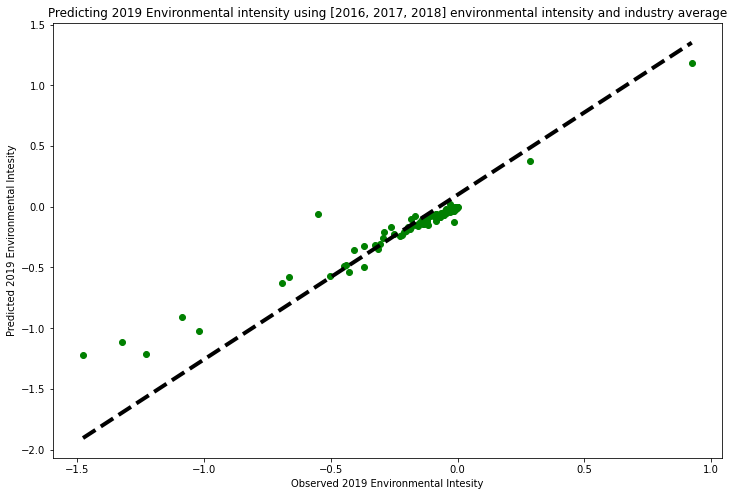

In [81]:
predictiveModel(2019, years, df_c)

Now, we are going to create another function that will create a predictive model using environmental intensity, industry average and industry indicator.

In [82]:
def predictiveModel1(outcomeYear, pastYears, df_c):
    years.sort()
    for year in years:
        data = df_c[df_c['Year'] == year]
        data = data.loc[:,['CompanyName','Env_intensity','industry_avg_year','Industry_indicator_year']]
        data.rename(columns={'Env_intensity': f'Env_intensity_{year}','industry_avg_year':f'industry_avg_year_{year}', 'Industry_indicator_year' : f'Industry_indicator_year_{year}'}, inplace=True) 
        if(year == min(years)):
            data1 = pd.DataFrame(data)
        else:
            data2 = pd.merge(data1, data, on=["CompanyName"])
            data1 = data2.copy()
    data3 = df_c[df_c['Year'] == outcomeYear]
    data3 = data3[['CompanyName','Env_intensity']]
    data3.rename(columns={'Env_intensity': f'Env_intensity_{outcomeYear}'}, inplace=True) 
    data3 = pd.merge(data3, data2, on=["CompanyName"])
    
    filter_col = [col for col in data3 if ((col.startswith('Env_intensity') and not(col.endswith(f'{outcomeYear}')))) or ((col.startswith('industry_avg_year') and not(col.endswith(f'{outcomeYear}')))) or ((col.startswith('Industry_indicator_year_') and not(col.endswith(f'{outcomeYear}'))))]            
    outcome_col = [col for col in data3 if (col.startswith('Env_intensity') and col.endswith(f'{outcomeYear}'))]
    X=data3[filter_col]
    y=data3[outcome_col]
    
    regr = linear_model.LinearRegression()
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
    regr.fit(X_train, y_train)
    y_train_pred = regr.predict(X_train)
    y_pred = regr.predict(X_test)

    print('MSE train: %.3f, test: %.3f' % (metrics.mean_squared_error(y_train, y_train_pred),
                    metrics.mean_squared_error(y_test, y_pred)))
    
    # display the parameters
    print('Model intercept: ', regr.intercept_)
    print('Model coefficients: ', regr.coef_)
    
    print('R2 score:', metrics.r2_score(y_test, y_pred))
    
    fig, ax = plt.subplots(figsize=(12,8))
    ax.scatter(y_test, y_pred, c='red')
    ax.plot([y_test.min(), y_test.max()], [y.min(), y.max()], 'k--', lw=4)
    ax.set_xlabel(f'Observed {outcomeYear} Environmental Intesity')
    ax.set_ylabel(f'Predicted {outcomeYear} Environmental Intesity')
    ax.set_title(f'Predicting {outcomeYear} Environmental intensity using {years} environmental intensity, industry average and industry indicator');

MSE train: 0.007, test: 0.003
Model intercept:  [-0.00054624]
Model coefficients:  [[-0.01778571 -0.14500433  0.00410858 -0.18026925 -0.09273773  0.00114723
   1.09366632  0.28265093 -0.00444881]]
R2 score: 0.9465508192299915


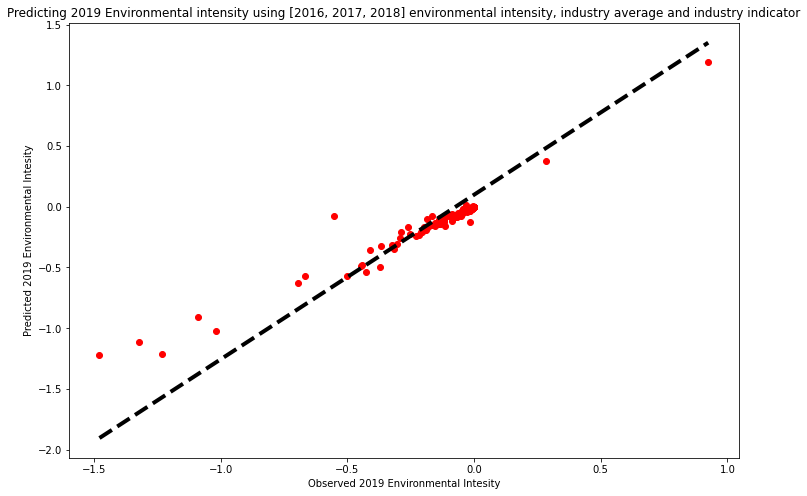

In [83]:
predictiveModel1(2019, years, df_c)

Now, we are going to create a third function that will create a predictive model using past years environmental intensity, industry average, industry indicator and environmental growth. 

In [84]:
def predictiveModel3(outcomeYear, pastYears, df_c):
    years.sort()
    for year in years:
        data = df_c[df_c['Year'] == year]
        data = data.loc[:,['CompanyName','Env_intensity','industry_avg_year','Industry_indicator_year','Environmental_Growth']]
        data.rename(columns={'Env_intensity': f'Env_intensity_{year}','industry_avg_year':f'industry_avg_year_{year}', 'Industry_indicator_year' : f'Industry_indicator_year_{year}', 'Environmental_Growth': f'Environmental_Growth_{year}'}, inplace=True) 
        if(year == min(years)):
            data1 = pd.DataFrame(data)
        else:
            data2 = pd.merge(data1, data, on=["CompanyName"])
            data1 = data2.copy()
    data2.dropna(inplace=True)
    data3 = df_c[df_c['Year'] == outcomeYear]
    data3 = data3[['CompanyName','Env_intensity']]
    data3.rename(columns={'Env_intensity': f'Env_intensity_{outcomeYear}'}, inplace=True) 
    data3 = pd.merge(data3, data2, on=["CompanyName"])
    
    filter_col = [col for col in data3 if ((col.startswith('Env_intensity') and not(col.endswith(f'{outcomeYear}')))) or ((col.startswith('industry_avg_year') and not(col.endswith(f'{outcomeYear}')))) or ((col.startswith('Industry_indicator_year_') and not(col.endswith(f'{outcomeYear}')))) or ((col.startswith('Environmental_Growth_') and not(col.endswith(f'{outcomeYear}'))))]            
    outcome_col = [col for col in data3 if (col.startswith('Env_intensity') and col.endswith(f'{outcomeYear}'))]
    X=data3[filter_col]
    y=data3[outcome_col]
    
    regr = linear_model.LinearRegression()
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
    regr.fit(X_train, y_train)
    y_train_pred = regr.predict(X_train)
    y_pred = regr.predict(X_test)

    print('MSE train: %.3f, test: %.3f' % (metrics.mean_squared_error(y_train, y_train_pred),
                    metrics.mean_squared_error(y_test, y_pred)))
    
    # display the parameters
    print('Model intercept: ', regr.intercept_)
    print('Model coefficients: ', regr.coef_)
    
    print('R2 score:', metrics.r2_score(y_test, y_pred))
    
    fig, ax = plt.subplots(figsize=(12,8))
    ax.scatter(y_test, y_pred, c='blue')
    ax.plot([y_test.min(), y_test.max()], [y.min(), y.max()], 'k--', lw=4)
    ax.set_xlabel(f'Observed {outcomeYear} Environmental Intesity')
    ax.set_ylabel(f'Predicted {outcomeYear} Environmental Intesity')
    ax.set_title(f'Predicting {outcomeYear} Environmental intensity using {years} environmental intensity, industry average, industry indicator and environmental growth');
    
    
    

MSE train: 0.007, test: 0.006
Model intercept:  [0.00042707]
Model coefficients:  [[-3.57050028e-02 -3.78767304e-01  7.82484846e-03  2.45351332e-04
  -3.35314980e-01  1.42406825e-01  5.22876608e-03 -1.84557134e-05
   1.22949797e+00  3.53350072e-01 -8.44622269e-03  1.62779214e-04]]
R2 score: 0.8928299824780621


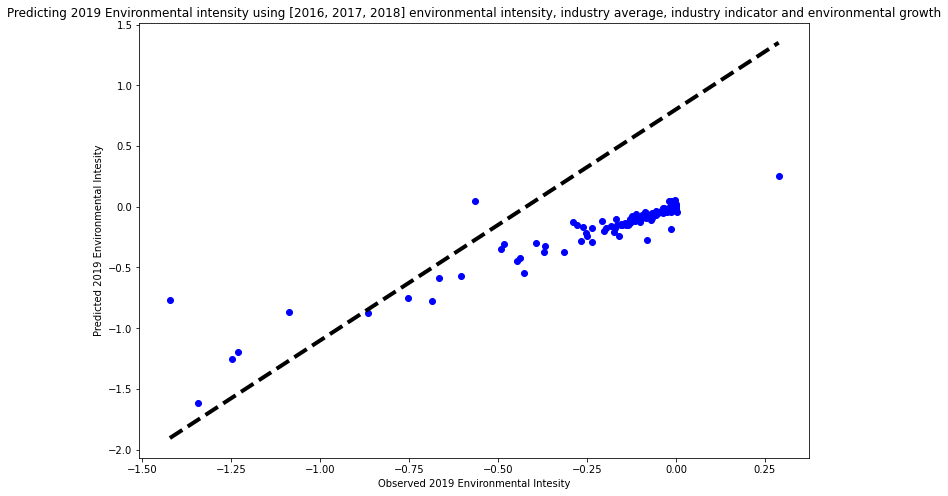

In [85]:
predictiveModel3(2019, years, df_c)

## Conclusion - Predictive models

Awesome results! By combining the predictors from the individual models, we were able to yield a lowers MSE and a higher R2 Score. When using past years environmental intensity and indsutry average, the linear model is able to explain 94.5% of the variance in the dataset. By including the industry indicator, it explains 94.6% and lastly, by including all four, it explains 90% of the variance. Even the lowest R2 Score (90%) was able to explain more than when considering the models with only one predictor. 

## Collect the Company Description

In this section, we will grab the company description directly from the Yahoo Finance website. We started with the pilot stocks but plan to see the possibility of mapping the ISIN with their corresponding ticker and be able to grab the company description

In [86]:
tickers_df = pd.read_csv('/Users/maralinetorres/Documents/GitHub/Predicting-Environmental-and-Social-Actions/Datasets/52_tickers_sectors.csv')

In [87]:
tickers = tickers_df.Ticker

In [88]:
# Create a loop to store URLs of all stocks' description page
URL = [] 
DES = [] 
comp_desc = {}
for i in tickers: 
  url ='https://finance.yahoo.com/quote/'+i+'/profile' 
  URL.append(url)
  page = requests.get(url) # visits the URL 
  htmldata = BeautifulSoup(page.content, 'html.parser')
  Business_Description = htmldata.find('p',{'class':'Mt(15px) Lh(1.6)'}) # finds the business description part in the HTML code
  DES.append(Business_Description)
  comp_desc[i] = [Business_Description]

In [89]:
df_comp_desc = pd.DataFrame.from_dict(comp_desc, orient='index', columns = ['Description'])
df_comp_desc.reset_index(inplace = True)
df_comp_desc.rename(columns = {'index':'Ticker'}, inplace=True)
df_comp_desc.head()

,Ticker,Description
0,AEE,None
1,AEP,None
2,AES,None
3,APA,None
4,ATO,None


In [90]:
df_comp_desc.to_csv('52ticker_companydescription.csv',index=False)

In the next sprint, we plan to do some text analysis to the company descriptions (tokenizations, sentiment, etc) and maybe consider adding the company description to the Sprint #4 models to better predict the GHG Scope 1. 